In [2]:
import torch
import numpy as np
import os
import time
import glob
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
from cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *

In [3]:



# Base directory containing all output folders
#base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/'
base_dir = '/Users/sarahurbut/Dropbox (Personal)/flatlambda/results/'
# List all output directories
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))

first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24554/3185620267.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di

In [35]:
disease_names = first_model['disease_names']
disease_names = disease_names[0].tolist()

In [7]:
# Load first model to get phi_kd
first_model = torch.load('/Users/sarahurbut/Dropbox (Personal)/flatlambda/results/output_0_10000/model.pt')
phi_kd = first_model['model_state_dict']['phi']  # Shape should be (K, D)
all_lambdas = np.load('/Users/sarahurbut/aladynoulli2/pyScripts/oldstuff/all_lambdas_combined_smallg_flatlam.npy')
# Calculate pi for all people
# all_lambdas shape is (N, K, T)
# phi_kd shape is (K, D)
# Need to calculate for each timepoint
T = all_lambdas.shape[2]
D = phi_kd.shape[1]


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24554/1679769425.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load('/Users/sarahurbut/D

In [8]:


# Convert to thetas first
all_thetas = torch.softmax(torch.tensor(all_lambdas), dim=1).numpy()

epsilon = 1e-8
# Convert lambdas to thetas


# Get phi probabilities
phi_prob = torch.sigmoid(torch.tensor(phi_kd)).numpy()



/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24554/1405816475.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_prob = torch.sigmoid(torch.tensor(phi_kd)).numpy()


In [9]:
# 1. Full calculation
print("Starting full calculation...")
start_time = time.time()
pi_pred = np.einsum('nkt,kdt->ndt', all_thetas, phi_prob)
print(f"Full calculation took: {(time.time() - start_time)/60:.2f} minutes")

# 2. Additional verification
print("\nVerification:")
print(f"Full pi shape: {pi_pred.shape}")
print(f"Range of values: [{pi_pred.min():.6f}, {pi_pred.max():.6f}]")
print(f"Mean value: {pi_pred.mean():.6f}")

Starting full calculation...
Full calculation took: 4.31 minutes

Verification:
Full pi shape: (400000, 348, 52)
Range of values: [0.000000, 0.006588]
Mean value: 0.000107


In [10]:
predicted_risk_2d = np.mean(pi_pred, axis=0)  # Shape will be (348, 52)

print("Predicted risk shape:", predicted_risk_2d.shape)  # Should be (348, 52)
print("Range of values:", predicted_risk_2d.min(), predicted_risk_2d.max())
print("Mean value:", predicted_risk_2d.mean())

Predicted risk shape: (348, 52)
Range of values: 5.019300762340592e-09 0.003911548667959649
Mean value: 0.00010658239086207922


In [11]:
# Get μ_dt from checkpoint and predictions
mu_dt = first_model['prevalence_t']  # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
print(scale_factor)


3.760171264247254


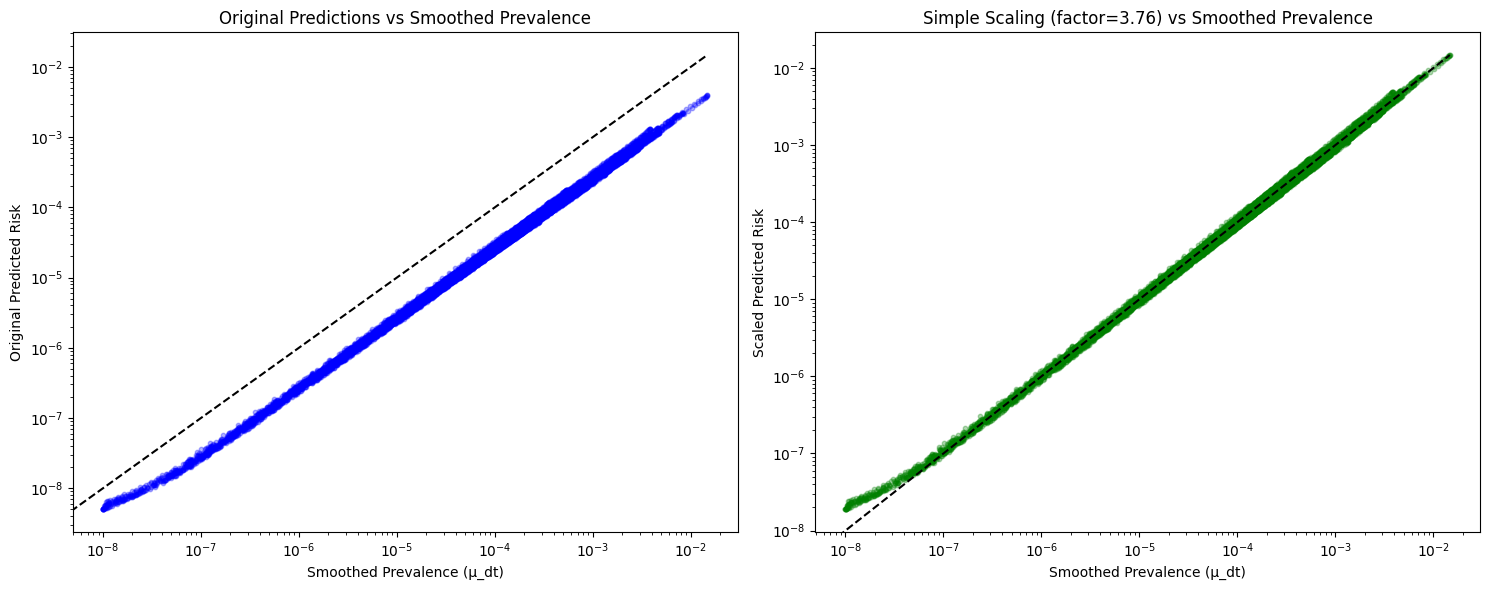

In [12]:

scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [14]:
def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()

# Function to find interesting

Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24554/1032044898.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


In [15]:
checkpoint = torch.load('/Users/sarahurbut/Dropbox (Personal)/flatlambda/results//output_0_10000/model.pt')
checkpoint['psi']

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24554/2411067842.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/Users/sarahurbut/Dr

Parameter containing:
tensor([[-2.0078, -1.9824, -2.0043,  ..., -1.9996, -1.9802, -2.0136],
        [-1.9952, -1.9690, -1.9960,  ..., -2.0071, -1.9960, -1.9912],
        [-1.9826, -1.9807, -2.0075,  ..., -2.0019, -1.9872, -2.0008],
        ...,
        [-1.9943, -2.0009, -1.9819,  ..., -1.9749, -2.0113, -2.0082],
        [-1.9980, -1.9918, -1.9897,  ..., -1.9871, -2.0033, -1.9954],
        [-5.0030, -5.0041, -5.0104,  ..., -5.0064, -4.9999, -5.0015]],
       requires_grad=True)

In [16]:
checkpoint = torch.load('/Users/sarahurbut/Dropbox (Personal)/flatlambda/results//output_20000_30000/model.pt')
checkpoint['psi']

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24554/2880514263.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/Users/sarahurbut/Dr

Parameter containing:
tensor([[-2.0078, -1.9824, -2.0043,  ..., -1.9997, -1.9802, -2.0136],
        [-1.9952, -1.9690, -1.9960,  ..., -2.0071, -1.9961, -1.9912],
        [-1.9826, -1.9807, -2.0075,  ..., -2.0019, -1.9872, -2.0008],
        ...,
        [-1.9943, -2.0009, -1.9819,  ..., -1.9749, -2.0113, -2.0082],
        [-1.9980, -1.9918, -1.9897,  ..., -1.9871, -2.0033, -1.9954],
        [-5.0030, -5.0041, -5.0104,  ..., -5.0064, -4.9999, -5.0015]],
       requires_grad=True)

In [17]:
checkpoint['model_state_dict']['lambda_'][0,:,10]

tensor([ 7.8501e-02,  6.0285e-02, -1.1132e-02,  5.3676e-02, -1.2883e-01,
         9.6395e-02, -3.8905e-03,  1.1469e-01,  1.3757e-01,  6.1846e-02,
         2.4398e-01, -6.7921e-03,  3.4320e-02,  1.2222e-01, -8.3115e-02,
        -6.8331e-02, -1.0389e-01,  9.4086e-03, -1.8413e-01, -1.0426e-01,
        -4.8907e+00])

In [18]:
all_lambdas[20000,:,10]

array([ 7.85012990e-02,  6.02849424e-02, -1.11318855e-02,  5.36757819e-02,
       -1.28832951e-01,  9.63948220e-02, -3.89045267e-03,  1.14692681e-01,
        1.37571886e-01,  6.18463643e-02,  2.43983567e-01, -6.79213973e-03,
        3.43198031e-02,  1.22222662e-01, -8.31153169e-02, -6.83310330e-02,
       -1.03885554e-01,  9.40855313e-03, -1.84125260e-01, -1.04259215e-01,
       -4.89066172e+00])

In [19]:
def print_disease_names(base_dir):
    """
    Print disease names from the first model's DataFrame
    """
    # Load first model
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    
    # Get disease names DataFrame
    disease_names_df = first_model['disease_names']
    
    print("\nAvailable diseases:")
    # Assuming the disease names are in a column - let's see the structure
    print("\nDataFrame structure:")
    print(disease_names_df.head())
    print("\nColumns:", disease_names_df.columns.tolist())
    
    return disease_names_df

# Look at the disease names DataFrame structure
disease_names_df = print_disease_names(base_dir)


Available diseases:

DataFrame structure:
                           0
0        Bacterial enteritis
1            Viral Enteritis
2   Gram negative septicemia
3    Bacterial infection NOS
4  Staphylococcus infections

Columns: [0]


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_24554/3415850116.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di

ASCVD Hazard scaling factor: 3.78


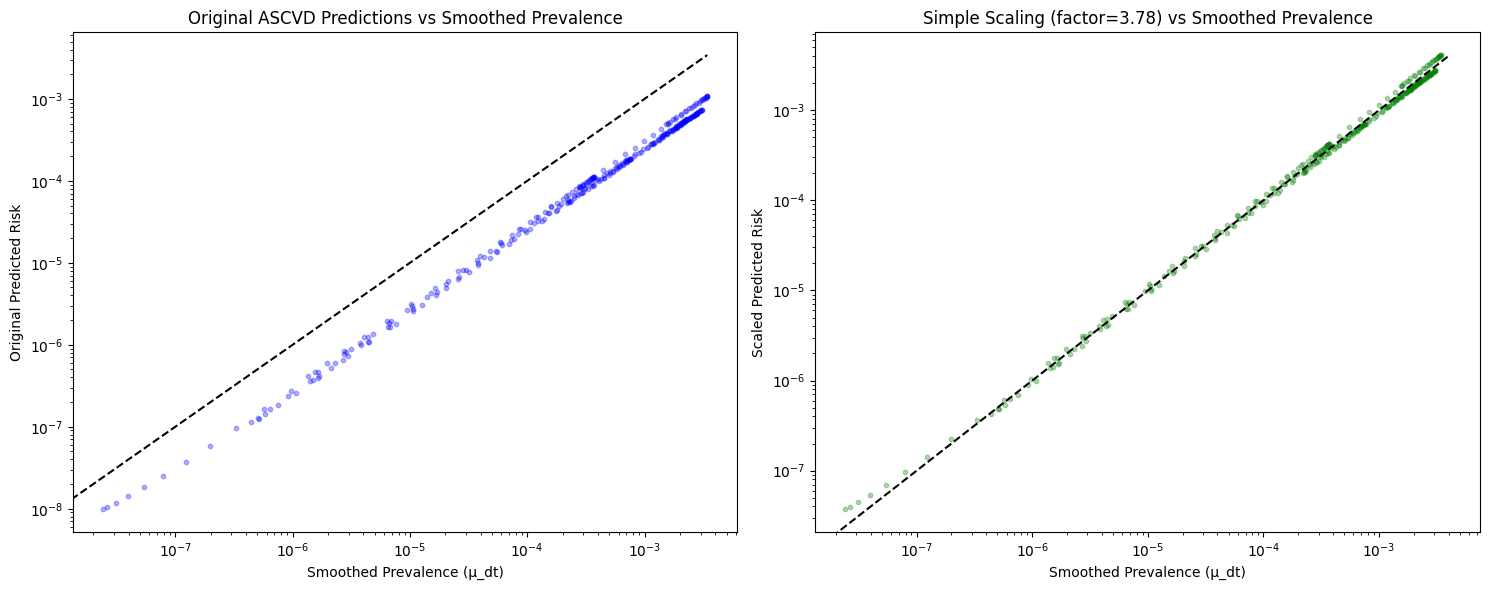

In [20]:
def calibrate_ascvd_hazards(pi_pred, first_model):
    """
    Calibrate ASCVD hazards using population-level rates
    """
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    
    # Get mean predictions across patients for each ASCVD condition and timepoint
    pred_risk = pi_pred[:, ascvd_indices, :].mean(axis=0)  # Shape: [6 diseases, 52 timepoints]
    
    # Get prevalence for ASCVD conditions
    if torch.is_tensor(first_model['prevalence_t']):
        mu_dt = first_model['prevalence_t'][ascvd_indices].cpu().numpy()
    else:
        mu_dt = first_model['prevalence_t'][ascvd_indices]
    
    # Calculate scaling factor from overall means
    scale_factor = np.mean(mu_dt) / np.mean(pred_risk)
    print(f"ASCVD Hazard scaling factor: {scale_factor:.2f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original predictions vs μ_dt
    ax1.scatter(mu_dt.flatten(), pred_risk.flatten(), 
               alpha=0.3, color='blue', s=10)
    ax1.plot([0, max(mu_dt.max(), pred_risk.max())], 
             [0, max(mu_dt.max(), pred_risk.max())], 
             'k--', label='x=y')
    ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax1.set_ylabel('Original Predicted Risk')
    ax1.set_title('Original ASCVD Predictions vs Smoothed Prevalence')
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    # Scaled predictions vs μ_dt
    scaled_risk = pred_risk * scale_factor
    ax2.scatter(mu_dt.flatten(), scaled_risk.flatten(), 
               alpha=0.3, color='green', s=10)
    ax2.plot([0, max(mu_dt.max(), scaled_risk.max())], 
             [0, max(mu_dt.max(), scaled_risk.max())], 
             'k--', label='x=y')
    ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
    ax2.set_ylabel('Scaled Predicted Risk')
    ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()
    

        
    return scale_factor

ascvd_scale=calibrate_ascvd_hazards(pi_pred=pi_pred,first_model=first_model)

In [21]:
ascvd_scale

np.float64(3.783451354272085)

In [22]:
patient_ids=np.load('/Users/sarahurbut/aladynoulli2/pyScripts/npys/processed_patient_ids.npy')

In [23]:
import pandas as pd 
# Try reading with rpy2 explicitly preserving row names
from rpy2.robjects import r

# Read with explicit row.names preservation
r('''
read_rds_with_names <- function(path) {
    df <- readRDS(path)
    attr(df, "row.names") <- rownames(df)
    df
}
''')

pce_df = r['read_rds_with_names']('/Users/sarahurbut/Dropbox (Personal)/pce_withnames.rds')

# Convert to pandas with index
pce_array = np.array(pce_df)
ages = range(40, 80)
pce_df = pd.DataFrame(pce_array, columns=ages)

# Print what we got
print("Shape:", pce_df.shape)
print("\nFirst few rows:")
print(pce_df.head())

# Or alternatively, we could read the row names separately:
row_names = r('rownames(readRDS("/Users/sarahurbut/Dropbox (Personal)/pce_withnames.rds"))')
pce_df.index = np.array(row_names)


Shape: (79117, 40)

First few rows:
     40    41    42    43    44    45    46    47    48    49  ...     70  \
0  3.25  3.63  4.05  4.50  4.98  5.51  6.08  6.69  7.34  8.04  ...  35.06   
1  2.05  2.30  2.56  2.85  3.16  3.50  3.86  4.25  4.67  5.12  ...  23.55   
2  1.00  1.00  1.00  1.00  1.00  1.00  1.04  1.13  1.22  1.33  ...  10.64   
3  1.89  1.95  2.02  2.11  2.21  2.33  2.46  2.60  2.76  2.94  ...  16.06   
4  1.31  1.38  1.46  1.56  1.67  1.79  1.93  2.08  2.25  2.44  ...  18.03   

      71     72     73     74     75     76     77     78     79  
0  36.92  38.82  40.75  42.72  44.71  46.73  48.77  50.82  52.88  
1  24.91  26.32  27.77  29.26  30.80  32.37  33.98  35.62  37.30  
2  11.80  13.09  14.51  16.07  17.79  19.68  21.74  23.98  26.42  
3  17.53  19.13  20.86  22.73  24.76  26.94  29.29  31.80  34.48  
4  19.88  21.90  24.10  26.49  29.08  31.86  34.85  38.04  41.42  

[5 rows x 40 columns]


In [24]:
# Get the row names from R
row_names = np.array(r('rownames(readRDS("/Users/sarahurbut/Dropbox (Personal)/pce_withnames.rds"))'))

# Create DataFrame with proper row names and age columns
pce_array = np.array(pce_df)
ages = range(40, 80)
pce_df = pd.DataFrame(pce_array, index=row_names, columns=ages)

print("Shape:", pce_df.shape)
print("\nFirst few rows:")
print(pce_df.head())

# Verify we have the right structure
print("\nIndex (row names) sample:", pce_df.index[:6])
print("Columns (ages):", pce_df.columns.tolist()[:5], "...", pce_df.columns.tolist()[-5:])

Shape: (79117, 40)

First few rows:
           40    41    42    43    44    45    46    47    48    49  ...  \
5021704  3.25  3.63  4.05  4.50  4.98  5.51  6.08  6.69  7.34  8.04  ...   
5021715  2.05  2.30  2.56  2.85  3.16  3.50  3.86  4.25  4.67  5.12  ...   
5021723  1.00  1.00  1.00  1.00  1.00  1.00  1.04  1.13  1.22  1.33  ...   
5021737  1.89  1.95  2.02  2.11  2.21  2.33  2.46  2.60  2.76  2.94  ...   
5021742  1.31  1.38  1.46  1.56  1.67  1.79  1.93  2.08  2.25  2.44  ...   

            70     71     72     73     74     75     76     77     78     79  
5021704  35.06  36.92  38.82  40.75  42.72  44.71  46.73  48.77  50.82  52.88  
5021715  23.55  24.91  26.32  27.77  29.26  30.80  32.37  33.98  35.62  37.30  
5021723  10.64  11.80  13.09  14.51  16.07  17.79  19.68  21.74  23.98  26.42  
5021737  16.06  17.53  19.13  20.86  22.73  24.76  26.94  29.29  31.80  34.48  
5021742  18.03  19.88  21.90  24.10  26.49  29.08  31.86  34.85  38.04  41.42  

[5 rows x 40 columns]

Ind

In [25]:

processed_ids=patient_ids
# Get intersection
pce_ids = set(pce_df.index)
processed_ids_set = set(processed_ids)
common_ids = pce_ids.intersection(processed_ids_set)

print(f"PCE patients: {len(pce_ids):,}")
print(f"Processed patients: {len(processed_ids_set):,}")
print(f"Intersection: {len(common_ids):,}")

# Convert intersection to list and sort for consistency
common_ids = sorted(list(common_ids))

# Create a subset of PCE data for just the overlapping patients
pce_subset = pce_df.loc[common_ids]
print("\nShape of PCE subset:", pce_subset.shape)
print("\nFirst few rows of subset:")
print(pce_subset.head())

PCE patients: 79,117
Processed patients: 400,000
Intersection: 59,896

Shape of PCE subset: (59896, 40)

First few rows of subset:
           40    41    42    43    44    45    46    47    48    49  ...  \
5021715  2.05  2.30  2.56  2.85  3.16  3.50  3.86  4.25  4.67  5.12  ...   
5021723  1.00  1.00  1.00  1.00  1.00  1.00  1.04  1.13  1.22  1.33  ...   
5021737  1.89  1.95  2.02  2.11  2.21  2.33  2.46  2.60  2.76  2.94  ...   
5021742  1.31  1.38  1.46  1.56  1.67  1.79  1.93  2.08  2.25  2.44  ...   
5021759  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  ...   

            70     71     72     73     74     75     76     77     78     79  
5021715  23.55  24.91  26.32  27.77  29.26  30.80  32.37  33.98  35.62  37.30  
5021723  10.64  11.80  13.09  14.51  16.07  17.79  19.68  21.74  23.98  26.42  
5021737  16.06  17.53  19.13  20.86  22.73  24.76  26.94  29.29  31.80  34.48  
5021742  18.03  19.88  21.90  24.10  26.49  29.08  31.86  34.85  38.04  41.42  
5021759   7.

In [27]:
# Get indices for ASCVD conditions and our common patients
ascvd_indices = [111, 112, 113, 114, 115, 116]

patient_mask = np.isin(patient_ids, common_ids)

# Extract predictions just for these patients and ASCVD conditions
ascvd_preds = pi_pred[patient_mask][:, ascvd_indices, :]

# Apply calibration factor
ascvd_preds_calibrated = ascvd_preds * ascvd_scale

print("Shape of calibrated predictions:", ascvd_preds_calibrated.shape)
print("Should be (n_common_patients, n_ascvd_conditions, n_timepoints)")
print(f"Expected: ({len(common_ids)}, 6, 52)")

# Verify we got the right patients
print("\nFirst few patient indices:", common_ids[:5])
print("\nSample of calibrated predictions for first patient, first condition:")
print(ascvd_preds_calibrated[0, 0, :10])  # First 10 timepoints

Shape of calibrated predictions: (59896, 6, 52)
Should be (n_common_patients, n_ascvd_conditions, n_timepoints)
Expected: (59896, 6, 52)

First few patient indices: ['5021715', '5021723', '5021737', '5021742', '5021759']

Sample of calibrated predictions for first patient, first condition:
[4.01115818e-07 4.55651649e-07 5.83243736e-07 8.27718036e-07
 1.27335005e-06 2.06858487e-06 3.45523827e-06 5.79212357e-06
 9.55415738e-06 1.52894823e-05]


In [28]:
base_dir

'/Users/sarahurbut/Dropbox (Personal)/flatlambda/results/'

In [29]:
def calculate_ten_year_risks(ascvd_preds, common_ids, max_age=70):
    """
    Calculate 10-year ASCVD risks for each patient at each age
    ascvd_preds starts at age 30, we want risks for ages 40-max_age
    """
    n_patients = len(common_ids)
    n_ages = max_age - 40 + 1  # e.g., ages 40-70 inclusive
    ten_year_risks = np.zeros((n_patients, n_ages))
    
    age_offset = 10  # Offset because predictions start at age 30
    
    for age_idx in range(n_ages):
        # For each starting age (40-70), look at next 10 years
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        
        # Get all predictions for this 10-year window
        window_preds = ascvd_preds[:, :, time_window]
        
        # Probability of surviving (no events)
        survival_probs = 1 - window_preds
        
        # Probability of surviving all diseases for all years
        total_survival = np.prod(survival_probs, axis=(1,2))
        
        # 10-year risk is probability of not surviving
        ten_year_risks[:, age_idx] = 1 - total_survival
    
    risk_df = pd.DataFrame(ten_year_risks * 100,
                          index=common_ids, 
                          columns=range(40, max_age + 1))
    
    return risk_df

# Calculate risks up to age 70
model_risks = calculate_ten_year_risks(ascvd_preds_calibrated, common_ids, max_age=70)

print("\nFirst few model predictions (%) up to age 70:")
print(model_risks.head())
print("\nCorresponding PCE predictions:")
print(pce_subset.iloc[:, :31].head())  # Show only up to age 70


First few model predictions (%) up to age 70:
               40        41        42        43        44        45        46  \
5021715  1.039371  1.300034  1.604746  1.956345  2.356691  2.806398  3.304375   
5021723  0.993838  1.239543  1.525529  1.854154  2.226910  2.644210  3.104990   
5021737  1.388307  1.720593  2.104256  2.541586  3.033700  3.580321  4.179356   
5021742  1.091830  1.366734  1.687558  2.056790  2.475766  2.944428  3.460916   
5021759  1.183146  1.476423  1.817397  2.208467  2.650869  3.144433  3.687164   

               47        48        49  ...         61         62         63  \
5021715  3.847573  4.430773  5.046589  ...  10.802199  10.831742  10.766861   
5021723  3.606493  4.144072  4.711184  ...  10.060551  10.096079  10.044709   
5021737  4.826717  5.516189  6.239541  ...  13.341071  13.473512  13.499563   
5021742  4.021390  4.619899  5.248470  ...  11.024363  11.056194  10.993196   
5021759  4.275057  4.901952  5.559625  ...  11.657471  11.712197  11.67

In [30]:
max_age=70
ascvd_indices = [111, 112, 113, 114, 115, 116]
mu_dt = first_model['prevalence_t'][ascvd_indices]  # [6 conditions, 52 timepoints]
n_ages = max_age - 40 + 1
ten_year_risks = np.zeros(n_ages)

age_offset = 10  # Start at age 40 (index 10) in prevalence data
    
for age_idx in range(n_ages):
    # Get 10 years of prevalence starting at this age
    start_idx = age_idx + age_offset
    time_window = slice(start_idx, start_idx + 10)
    window_prev = mu_dt[:, time_window]  # [6 conditions, 10 years]
    
    # Calculate survival probability across all conditions and years
    survival_prob = np.prod(1 - window_prev)
    
    # 10-year risk is 1 - survival probability
    ten_year_risks[age_idx] = (1 - survival_prob) * 100  # percentage
   

In [31]:
start_idx = age_idx + age_offset
time_window = slice(start_idx, start_idx + 10)
window_prev = mu_dt[:, time_window]  # [6 conditions, 10 years]


In [32]:
def calculate_prevalence_10yr_risk(first_model, max_age=70):
    """
    Calculate 10-year risk from smoothed prevalence rates
    For each age:
    1. For each year t in next 10 years:
       - Calculate P(any ASCVD in year t) = 1 - prod(1 - p_disease_t)
    2. Calculate 10-year survival = prod(1 - P(any ASCVD in year t))
    3. 10-year risk = 1 - 10-year survival
    """
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    mu_dt = first_model['prevalence_t'][ascvd_indices]  # [6 conditions, 52 timepoints]
    
    n_ages = max_age - 40 + 1
    ten_year_risks = np.zeros(n_ages)
    age_offset = 10  
    
    for age_idx in range(n_ages):
        start_idx = age_idx + age_offset
        time_window = slice(start_idx, start_idx + 10)
        window_prev = mu_dt[:, time_window]  # [6 conditions, 10 years]
        
        # For each year, calculate P(any ASCVD)
        yearly_any_ascvd = np.zeros(10)
        for year in range(10):
            # Probability of no disease for each condition this year
            no_disease_probs = 1 - window_prev[:, year]
            # Probability of no ASCVD this year
            no_ascvd = np.prod(no_disease_probs)
            # Probability of any ASCVD this year
            yearly_any_ascvd[year] = 1 - no_ascvd
        
        # Calculate 10-year survival probability
        ten_year_survival = np.prod(1 - yearly_any_ascvd)
        
        # 10-year risk
        ten_year_risks[age_idx] = (1 - ten_year_survival) * 100
    
    return ten_year_risks

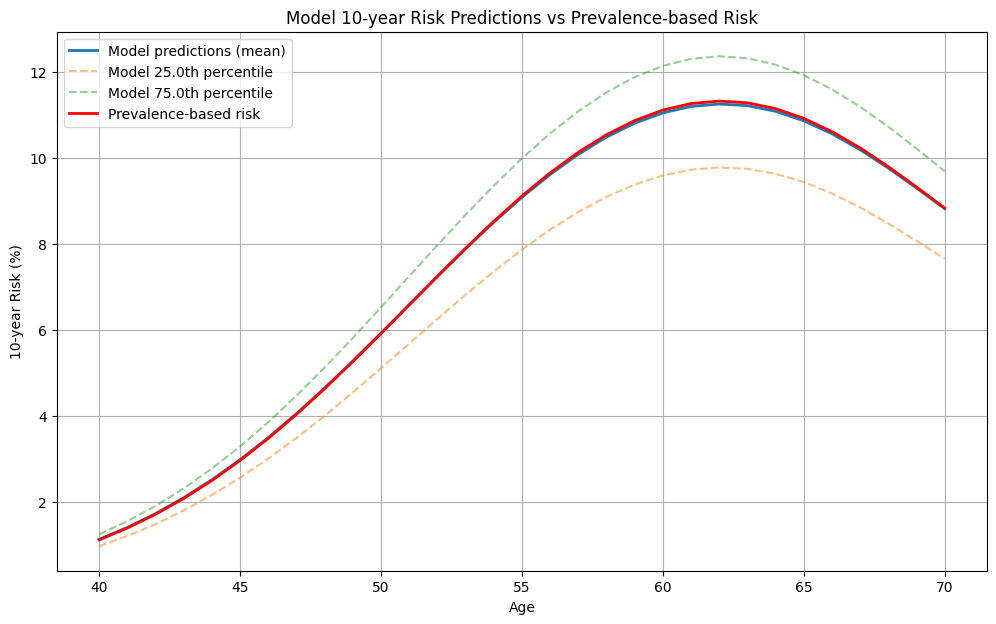


Comparison at specific ages:

Age 40:
Prevalence-based risk: 1.11%
Model mean prediction: 1.12%
Model 25-75th percentile: [0.96%, 1.24%]

Age 50:
Prevalence-based risk: 5.91%
Model mean prediction: 5.92%
Model 25-75th percentile: [5.10%, 6.52%]

Age 60:
Prevalence-based risk: 11.10%
Model mean prediction: 11.04%
Model 25-75th percentile: [9.59%, 12.13%]

Age 70:
Prevalence-based risk: 8.83%
Model mean prediction: 8.81%
Model 25-75th percentile: [7.65%, 9.68%]


In [33]:
# Calculate prevalence-based risks
prev_10yr_risk = calculate_prevalence_10yr_risk(first_model)

plt.figure(figsize=(12, 7))

# Plot average model predictions
plt.plot(range(40, 71), model_risks.mean(), 
         label='Model predictions (mean)', 
         linewidth=2)

# Plot prediction quantiles
quantiles = [0.25, 0.75]
for q in quantiles:
    plt.plot(range(40, 71), model_risks.quantile(q), 
            '--', alpha=0.5,
            label=f'Model {q*100}th percentile')

# Plot prevalence-based risk
plt.plot(range(40, 71), prev_10yr_risk, 
         'r-', label='Prevalence-based risk',
         linewidth=2)

plt.xlabel('Age')
plt.ylabel('10-year Risk (%)')
plt.title('Model 10-year Risk Predictions vs Prevalence-based Risk')
plt.legend()
plt.grid(True)
plt.show()

# Print some numerical comparisons
print("\nComparison at specific ages:")
for age in [40, 50, 60, 70]:
    idx = age - 40
    print(f"\nAge {age}:")
    print(f"Prevalence-based risk: {prev_10yr_risk[idx]:.2f}%")
    print(f"Model mean prediction: {model_risks[age].mean():.2f}%")
    print(f"Model 25-75th percentile: [{model_risks[age].quantile(0.25):.2f}%, {model_risks[age].quantile(0.75):.2f}%]")

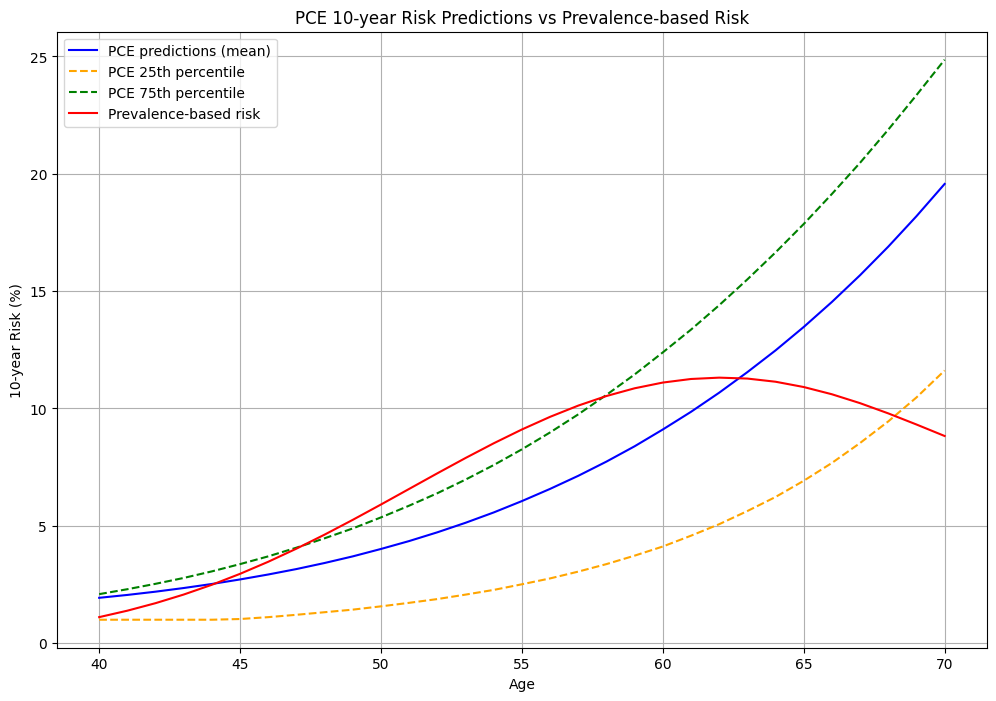

In [34]:
# Get PCE predictions for ages 40-70 only
pce_mean = pce_subset.iloc[:, :31].mean()  # first 31 columns (40-70)
pce_25 = pce_subset.iloc[:, :31].quantile(0.25)
pce_75 = pce_subset.iloc[:, :31].quantile(0.75)

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(range(40, 71), pce_mean, label='PCE predictions (mean)', color='blue')
plt.plot(range(40, 71), pce_25, '--', label='PCE 25th percentile', color='orange')
plt.plot(range(40, 71), pce_75, '--', label='PCE 75th percentile', color='green')
plt.plot(range(40, 71),prev_10yr_risk, 'r-', label='Prevalence-based risk')

plt.xlabel('Age')
plt.ylabel('10-year Risk (%)')
plt.title('PCE 10-year Risk Predictions vs Prevalence-based Risk')
plt.grid(True)
plt.legend()
plt.show()

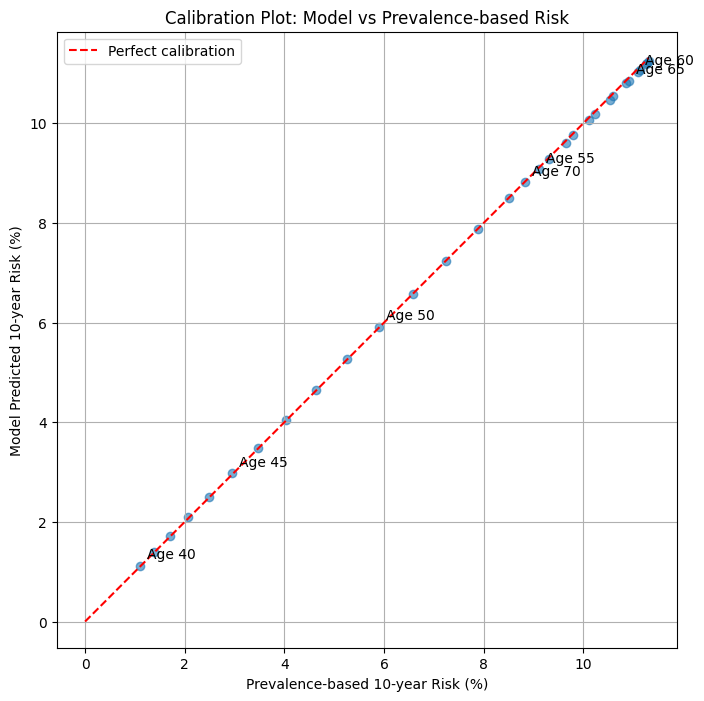

R² score: 1.000

Risk comparisons at key ages:
Age 40: Prevalence = 1.11%, Model = 1.12%
Age 50: Prevalence = 5.91%, Model = 5.92%
Age 60: Prevalence = 11.10%, Model = 11.04%
Age 70: Prevalence = 8.83%, Model = 8.81%


In [35]:
# Get model predictions and prevalence risks
model_means = model_risks.mean()  # This is indexed by age (40-70)
prev_risks = pd.Series(prev_10yr_risk, index=range(40, 71))  # Make prev_risks match the age indexing

plt.figure(figsize=(8, 8))

# Scatter plot of predicted vs actual
plt.scatter(prev_risks, model_means, alpha=0.6)

# Add diagonal reference line
max_risk = max(max(prev_risks), max(model_means))
plt.plot([0, max_risk], [0, max_risk], 'r--', label='Perfect calibration')

# Add labels and title
plt.xlabel('Prevalence-based 10-year Risk (%)')
plt.ylabel('Model Predicted 10-year Risk (%)')
plt.title('Calibration Plot: Model vs Prevalence-based Risk')

# Add age labels to points
for age in range(40, 71, 5):
    plt.annotate(f'Age {age}', 
                (prev_risks[age], model_means[age]),
                xytext=(5, 5), textcoords='offset points')

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

# Print calibration metrics
from sklearn.metrics import r2_score
print(f"R² score: {r2_score(prev_risks, model_means):.3f}")
print("\nRisk comparisons at key ages:")
for age in [40, 50, 60, 70]:
    print(f"Age {age}: Prevalence = {prev_risks[age]:.2f}%, Model = {model_means[age]:.2f}%")

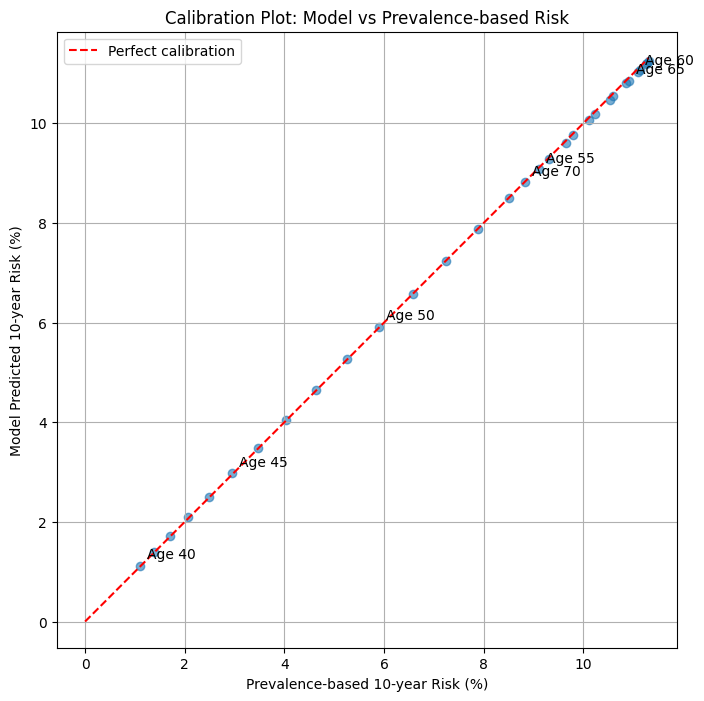

R² score: 1.000

Risk comparisons at key ages:
Age 40: Prevalence = 1.11%, Model = 1.12%
Age 50: Prevalence = 5.91%, Model = 5.92%
Age 60: Prevalence = 11.10%, Model = 11.04%
Age 70: Prevalence = 8.83%, Model = 8.81%


In [36]:
# Get values directly as arrays for plotting
prev_values = prev_10yr_risk
model_values = model_risks.mean().values

plt.figure(figsize=(8, 8))

# Scatter plot of predicted vs actual
plt.scatter(prev_values, model_values, alpha=0.6)

# Add diagonal reference line
max_risk = max(max(prev_values), max(model_values))
plt.plot([0, max_risk], [0, max_risk], 'r--', label='Perfect calibration')

# Add labels and title
plt.xlabel('Prevalence-based 10-year Risk (%)')
plt.ylabel('Model Predicted 10-year Risk (%)')
plt.title('Calibration Plot: Model vs Prevalence-based Risk')

# Add age labels to points (using array indices)
for i, age in enumerate(range(40, 71, 5)):
    idx = age - 40
    plt.annotate(f'Age {age}', 
                (prev_values[idx], model_values[idx]),
                xytext=(5, 5), textcoords='offset points')

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

# Print calibration metrics
print(f"R² score: {r2_score(prev_values, model_values):.3f}")
print("\nRisk comparisons at key ages:")
for age in [40, 50, 60, 70]:
    idx = age - 40
    print(f"Age {age}: Prevalence = {prev_values[idx]:.2f}%, Model = {model_values[idx]:.2f}%")

Age 40: Our AUC = 0.673, PCE AUC = 0.651
Age 41: Our AUC = 0.676, PCE AUC = 0.657
Age 42: Our AUC = 0.669, PCE AUC = 0.661
Age 43: Our AUC = 0.665, PCE AUC = 0.656
Age 44: Our AUC = 0.665, PCE AUC = 0.656
Age 45: Our AUC = 0.666, PCE AUC = 0.662
Age 46: Our AUC = 0.668, PCE AUC = 0.660
Age 47: Our AUC = 0.665, PCE AUC = 0.657
Age 48: Our AUC = 0.662, PCE AUC = 0.660
Age 49: Our AUC = 0.657, PCE AUC = 0.659
Age 50: Our AUC = 0.656, PCE AUC = 0.663
Age 51: Our AUC = 0.655, PCE AUC = 0.662
Age 52: Our AUC = 0.654, PCE AUC = 0.660
Age 53: Our AUC = 0.649, PCE AUC = 0.664
Age 54: Our AUC = 0.647, PCE AUC = 0.665
Age 55: Our AUC = 0.644, PCE AUC = 0.665
Age 56: Our AUC = 0.642, PCE AUC = 0.665
Age 57: Our AUC = 0.635, PCE AUC = 0.663
Age 58: Our AUC = 0.631, PCE AUC = 0.662
Age 59: Our AUC = 0.627, PCE AUC = 0.663
Age 60: Our AUC = 0.621, PCE AUC = 0.664
Age 61: Our AUC = 0.614, PCE AUC = 0.664
Age 62: Our AUC = 0.613, PCE AUC = 0.664
Age 63: Our AUC = 0.609, PCE AUC = 0.661
Age 64: Our AUC 

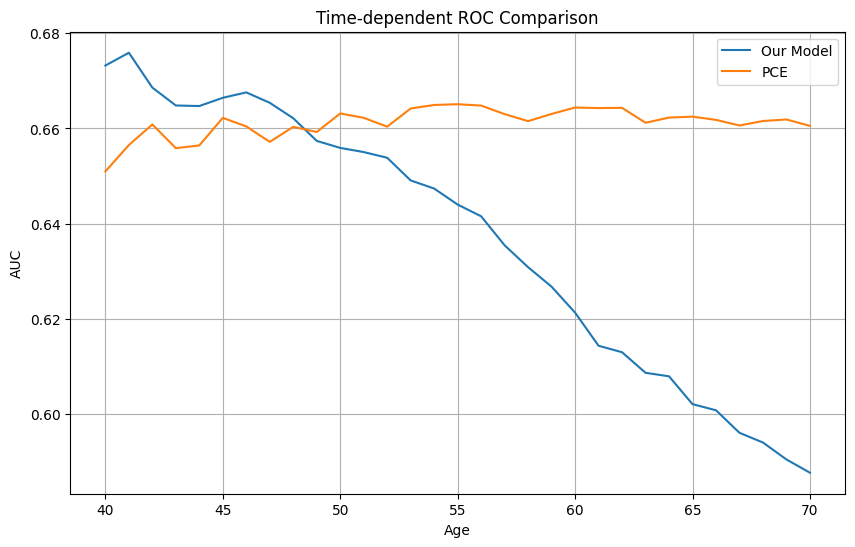

In [37]:
from sklearn.metrics import roc_auc_score

def calculate_time_dependent_roc(model_risks, pce_subset, Y, patient_ids, common_ids, ages=range(40, 71)):
    """
    Calculate ROC curves for both models at each age
    """
    # Get ASCVD events for our subset of patients
    ascvd_indices = [111, 112, 113, 114, 115, 116]
    
    # First subset Y to first 400K patients
    Y_subset = Y[:400000]
    
    # Then get our common patients
    patient_mask = np.isin(patient_ids, common_ids)
    ascvd_events = Y_subset[patient_mask][:, ascvd_indices]
    
    results = []
    for age in ages:
        # Get predictions at this age
        our_preds = model_risks[age].values  # Convert to numpy
        pce_preds = pce_subset[age].values   # Convert to numpy
        
        # Get outcomes in next 10 years from this age
        start_idx = age - 30  # Convert age to index
        # Use torch operations for the 3D tensor
        outcome = torch.any(torch.any(ascvd_events[..., start_idx:start_idx+10], dim=1), dim=1)
        outcome = outcome.numpy()  # Convert to numpy for sklearn
        
        # Calculate AUC for both models
        our_auc = roc_auc_score(outcome, our_preds)
        pce_auc = roc_auc_score(outcome, pce_preds)
        
        results.append({
            'age': age,
            'our_auc': our_auc,
            'pce_auc': pce_auc
        })
        
        # Print progress
        print(f"Age {age}: Our AUC = {our_auc:.3f}, PCE AUC = {pce_auc:.3f}")
    
    return pd.DataFrame(results)

# Calculate ROCs
roc_results = calculate_time_dependent_roc(model_risks, pce_subset, Y, patient_ids, common_ids)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(roc_results['age'], roc_results['our_auc'], label='Our Model')
plt.plot(roc_results['age'], roc_results['pce_auc'], label='PCE')
plt.xlabel('Age')
plt.ylabel('AUC')
plt.title('Time-dependent ROC Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
def compute_first_year_roc(pi, Y, event_times, patient_ids, common_ids, pce_subset, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare ROC at age 40 (first prediction age)
    """
    # Convert to numpy and get common patients
    pce_array = pce_subset.values if hasattr(pce_subset, 'values') else pce_subset
    common_mask = np.isin(patient_ids, common_ids)
    
    # Subset everything to common patients and convert to numpy
    pi_common = pi[common_mask]
    Y_common = Y[common_mask].detach().numpy() if torch.is_tensor(Y) else Y[common_mask]
    event_times_common = event_times[common_mask].detach().numpy() if torch.is_tensor(event_times) else event_times[common_mask]
    
    # Subset to ASCVD events
    pi_ascvd = pi_common[:, ascvd_indices]*ascvd_scale
    Y_ascvd = Y_common[:, ascvd_indices]
    event_times_ascvd = event_times_common[:, ascvd_indices]
    
    # Look at t=10 (age 40)
    t = 10
    our_pred_t = np.max(pi_ascvd[:,:,t], axis=1)
    pce_pred_t = pce_array[:,0]  # First PCE prediction
    
    # Events during first year
    events_t = np.max((event_times_ascvd >= t) & (event_times_ascvd < t+1), axis=1)
    mask = np.max(event_times_ascvd > t-1, axis=1)
    
    # Compute ROCs
    our_auc = roc_auc_score(events_t[mask], our_pred_t[mask])
    pce_auc = roc_auc_score(events_t[mask], pce_pred_t[mask])
    
    return our_auc, pce_auc

In [40]:

# Usage:
Y_subset = Y[:400000]
E_subset = E[:400000]
our_aucs, pce_aucs = compute_first_year_roc(
    pi_pred, 
    Y_subset,
    event_times=E_subset,
    patient_ids=patient_ids, 
    common_ids=common_ids,
    pce_subset=pce_subset,
    ascvd_indices=[111,112,113,114,115,116]
)

In [41]:
our_aucs


np.float64(0.7689450743975552)

In [42]:
pce_aucs

np.float64(0.7126417394499089)

In [ ]:
def compute_yearly_roc_comparison(pi, Y, event_times, patient_ids, common_ids, pce_subset, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare yearly ROCs between our model and PCE for ages 40-70
    """
    # Convert PCE to numpy if it's a DataFrame
    pce_array = pce_subset.values if hasattr(pce_subset, 'values') else pce_subset
    
    # Get common patients
    common_mask = np.isin(patient_ids, common_ids)
    
    # Subset everything to common patients and convert to numpy
    pi_common = pi[common_mask] # Convert torch to numpy
    Y_common = Y[common_mask].detach().numpy() if torch.is_tensor(Y) else Y[common_mask]
    event_times_common = event_times[common_mask].detach().numpy() if torch.is_tensor(event_times) else event_times[common_mask]
    
    # Subset to ASCVD events
    pi_ascvd = pi_common[:, ascvd_indices]*ascvd_scale
    Y_ascvd = Y_common[:, ascvd_indices]
    event_times_ascvd = event_times_common[:, ascvd_indices]
    
    our_aucs = []
    pce_aucs = []
    
    for t in range(10, 40):  # Ages 40-70
        our_pred_t = np.max(pi_ascvd[:,:,t], axis=1)  # Use numpy max
        pce_pred_t = pce_array[:,t-10]
        
        # Events that occur during year t
        events_t = np.max((event_times_ascvd >= t) & (event_times_ascvd < t+1), axis=1)
        
        # Only include individuals at risk
        mask = np.max(event_times_ascvd > t-1, axis=1)
        
        if np.sum(mask) > 0:
            our_auc = roc_auc_score(events_t[mask], our_pred_t[mask])
            pce_auc = roc_auc_score(events_t[mask], pce_pred_t[mask])
            our_aucs.append(our_auc)
            pce_aucs.append(pce_auc)
    
    return our_aucs, pce_aucs

our_aucs, pce_aucs = compute_yearly_roc_comparison(
    pi_pred, 
    Y_subset,
    event_times=E_subset,
    patient_ids=patient_ids, 
    common_ids=common_ids,
    pce_subset=pce_subset,
    ascvd_indices=[111,112,113,114,115,116]
)
# Plot with correct ages
plt.figure(figsize=(10,6))
plt.plot(range(40,70), our_aucs, label='Our Model')
plt.plot(range(40,70), pce_aucs, label='PCE')
plt.xlabel('Age')
plt.ylabel('1-year AUC')
plt.legend()
plt.title('Yearly ROC Comparison')
plt.grid(True)

